# Import

In [1]:
# Клонируем репозитерий stylegan2-ada-pytorch
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/stylegan2-ada-pytorch

Cloning into '/content/stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 3.70 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
# Скачиваем модель StyleGAN2
!mkdir -p /content/StyleGAN2
!wget -q https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -O /content/StyleGAN2/ffhq.pkl # модель обученная на датасете ffhq(лица)

In [3]:
!pip install -q git+https://github.com/openai/CLIP.git # установка CLIP
!pip install -q ninja # утилита для сборки C++/CUDA кода
!pip install -q youtokentome # библиотека от Яндекса для работы с BPE-токенизатором

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
import sys
import os
sys.path.append('/content/stylegan2-ada-pytorch')
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

import pickle
import copy

import numpy as np

import clip

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
from torchvision.transforms import transforms

from PIL import Image
import matplotlib.pyplot as plt

import re

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

RAND = 2

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [3]:
def cleaned_text(text) -> str:
    """
    Простая очистка текста
    """
    text = str(text) if text is not None else '' # преобразование text в строку, если это не строка
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9\s.,*!?:-]', '', text)  # удаление лишних символов (кроме пунктуации)
    text = re.sub(r'\s+', ' ', text).strip()  # удаление лишних пробелов
    text = re.sub(r'^[^\w]+', '', text)  # удаление пунктуации в начале строки
    text = text.strip(' .')  # убирает лишние пробелы и точки в начале и в конце строки
    return text

In [4]:
def preprocessing_text(text: str,
                       device) -> torch.Tensor:
  """
  Делает простую очистку текста, токенизирует и возвращает эмбеддинги
  """
  model.eval()
  with torch.no_grad():
    text = cleaned_text(text)
    text_tokenize = clip.tokenize(text).to(device)
    text_features = model.encode_text(text_tokenize)

  return text_features.detach()

In [5]:
def preprocessing_image(image,
                        device) -> torch.Tensor:
    """
    Если torch.Tensor, то преобразует его в PIL, делает препроцессинг
    и возвращает эмбеддинги изображения
    """
    model.eval()
    if isinstance(image, torch.Tensor):
      # Для torch.Tensor из StyleGAN2 с диапазоном [-1,1]
      transform = transforms.Compose([
          transforms.Lambda(lambda x: ((x + 1) / 2).clamp(0, 1)),
          transforms.Lambda(lambda x: F.interpolate(x,
                                                    size=(224, 224),
                                                    mode='bilinear',
                                                    align_corners=False)),
          transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                               std=(0.26862954, 0.26130258, 0.27577711))])

      image_preproc = transform(image.to(device))

      #image = ((image + 1) / 2).clamp(0, 1) # [-1, 1] → [0, 1]
      #image = (image * 255).to(torch.uint8) # конвертируем в диапазон [0, 255] и в тип uint8
      #image = image.permute(0, 2, 3, 1).cpu().numpy() # меняем формат с CHW → HWC и преобразуем в np.array
      #image = [Image.fromarray(img) for img in image] # cоздаём PIL.Image
      #image_preproc = torch.stack([preprocess(img) for img in image]).to(device)
    else:
      # Для PIL-изображений
      image_preproc = preprocess(image).unsqueeze(0).to(device)

    image_features = model.encode_image(image_preproc)

    return image_features

In [ ]:
# Загружаем свое фото
image =Image.open('/content/kot.jpg')

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')
plt.show()

# StyleGN2-ADA

In [14]:
with open('/content/StyleGAN2/ffhq.pkl', 'rb') as f:
  G = pickle.load(f)['G_ema'].to(device)

G_frozen = copy.deepcopy(G) # копия генератора (замороженный)

In [15]:
torch.cuda.manual_seed(RAND)

z = torch.randn(4, G.z_dim, device=device)
c = None
G.eval()
image_gan = G(z, c, truncation_psi=0.7, noise_mode='const')

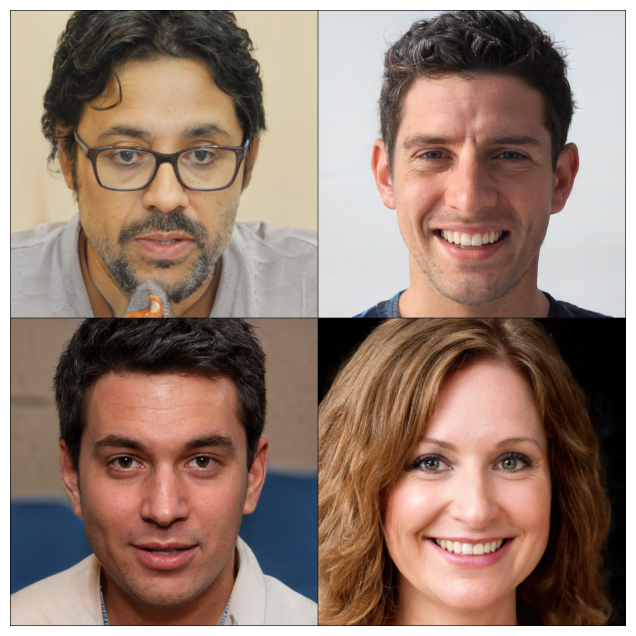

In [8]:
img = ((image_gan +  1) / 2).clamp(0, 1)  # [-1, 1] → [0, 1]
grid = make_grid(img, nrow=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()

# CLIP

In [8]:
# Загружаем модель и процессор
model, preprocess = clip.load('ViT-B/32', device=device)

In [13]:
text_features = preprocessing_text('woman', device)

In [14]:
image_features = preprocessing_image(image_gan, device)

# Train

## Loss

### cosine_dist

In [10]:
def cosine_dist(text_features: torch.Tensor,
                image_features: torch.Tensor) -> torch.Tensor:
 """
 Считает глобальный CLIP-loss (cosine distance)

 :param text_features: вектора текста в пространстве CLIP
 :param image_features: вектора изображения в пространстве CLIP

 :return delta_text: косинусное расстояние
 """
 cosine_dist = 1 - F.cosine_similarity(image_features, text_features, dim=1)
 return cosine_dist

### clip_loss

In [9]:
def delta_text(model,
               preprocess_text,
               text_target: str,
               text_source: str) -> torch.Tensor:
  """
  Считает вектор текстового направления (между таргетом и текущим стилем)

  :param model: модель CLIP
  :param preprocess_text: препроцессор модели CLIP для текста
  :param text_target: текст целевого стиля
  :param text_source: текст исходного стиля

  :return delta_text: вектор текстового направления
  """
  delta_text = preprocessing_text(text_target, device) - preprocessing_text(text_source, device)
  return delta_text

In [10]:
def delta_image(model,
                preprocess_image,
                gen,
                gen_frozen) -> torch.Tensor:
  """
  Считает вектор визуального направления (между изображением до и после fine-tuning)

  :param model: модель CLIP
  :param preprocess_image: препроцессор модели CLIP для изображения
  :param gen: обучаемый генератор StyleGAN2
  :param gen_frozen: замороженный генератор StyleGAN2

  :return delta_image: вектор визуального направления
  """
  # Создает генератор случайных чисел и инициализирует его определённым значением
  g = torch.Generator()
  g.manual_seed(RAND)

  # Генерирует латентный вектор из нормального распределения
  z = torch.randn(2, G.z_dim, device=device)

  c = None # метки класса

  gen.eval()
  gen_frozen.eval()

  # Генерирует изображение
  image = gen(z, c, truncation_psi=0.7, noise_mode='const')
  image_frozen = gen_frozen(z, c, truncation_psi=0.7, noise_mode='const')

  delta_image = preprocessing_image(image, device) - preprocessing_image(image_frozen, device)
  return delta_image

In [9]:
def clip_loss(delta_image: torch.Tensor,
              delta_text: torch.Tensor) -> torch.Tensor:
  """
  Ситает направленный CLIP-loss

  :param model: модель CLIP
  :param preprocess_text: препроцессор модели CLIP для текста
  :param text_target: текст целевого стиля
  :param text_source: текст исходного стиля
  :param preprocess_image: препроцессор модели CLIP для изображения
  :param gen: обучаемый генератор StyleGAN2
  :param gen_frozen: замороженный генератор StyleGAN2

  :return loss_clip: направленный CLIP-loss
  """

  loss_clip = 1 - F.cosine_similarity(delta_image, delta_text, dim=1)
  return loss_clip.mean()

## Train

### cosine_dist

In [22]:
def train_generator(generator,
                    generator_frozen,
                    model,
                    preprocess,
                    latent,
                    text,
                    epochs,
                    criterion,
                    device,
                    lr=0.0003,
                    c=None):
  """
  Обучает генератор StyleGAN2
  """
  loss_lst = []

  os.makedirs('results', exist_ok=True)

  optimizer = torch.optim.AdamW(generator.parameters(), lr=lr)

  generator.train()
  for param in generator.parameters():
    param.requires_grad = True

  for i in tqdm(range(epochs)):
    torch.cuda.empty_cache()
    optimizer.zero_grad()

    image = generator(latent, c, truncation_psi=0.7, noise_mode='const')

    text_features = preprocessing_text(text, device)
    image_features = preprocessing_image(image, device)

    loss = criterion(text_features, image_features)
    loss.backward()
    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {i + 1}: loss={loss.item():.4f}')

    if i % 50 == 0:
      img = (image.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
      grid = make_grid(img, nrow=2)

      save_path = f'results/generated_image_epoch_{i}.jpg'
      save_image(grid, save_path, 'jpeg')

      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

In [ ]:
train_generator(generator=G,
                generator_frozen=G_frozen,
                model=model,
                preprocess=preprocess,
                latent=z,
                text='скетч',
                epochs=301,
                criterion=cosine_dist,
                device=device)

### clip_loss

In [12]:
def train_generator(generator,
                    generator_frozen,
                    model,
                    preprocess,
                    preprocess_text,
                    preprocess_image,
                    latent,
                    latent_sample,
                    text_source,
                    text_target,
                    epochs,
                    criterion,
                    device,
                    lr=0.002,
                    c=None):
  """
  Обучает генератор StyleGAN2
  """
  loss_lst = []

  os.makedirs('results', exist_ok=True)

  optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

  generator.train()
  generator_frozen.eval()
  for param in generator.parameters():
    param.requires_grad = True

  for param in generator_frozen.parameters():
    param.requires_grad = False

  for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    image = generator(latent,
                      c,
                      truncation_psi=0.7,
                      noise_mode='const')
    image_frozen = generator_frozen(latent,
                                    c,
                                    truncation_psi=0.7,
                                    noise_mode='const')

    delta_image = preprocessing_image(image,
                                      device) - preprocessing_image(image_frozen,
                                                                    device)
    delta_text = preprocessing_text(text_target,
                                    device) - preprocessing_text(text_source,
                                                                 device)

    loss = criterion(delta_image,
                     delta_text)

    loss.backward()
    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {i + 1}: loss={loss.item():.4f}')

    if i % 50 == 0:
      image_sample = generator(latent_sample,
                               c,
                               truncation_psi=0.7,
                               noise_mode='const')
      img = (image_sample.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
      grid = make_grid(img, nrow=2)

      save_path = f'results/generated_image_epoch_{i}.jpg'
      save_image(grid, save_path, 'jpeg')

      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

  0%|          | 0/301 [00:00<?, ?it/s]

Эпоха 1: loss=1.0039


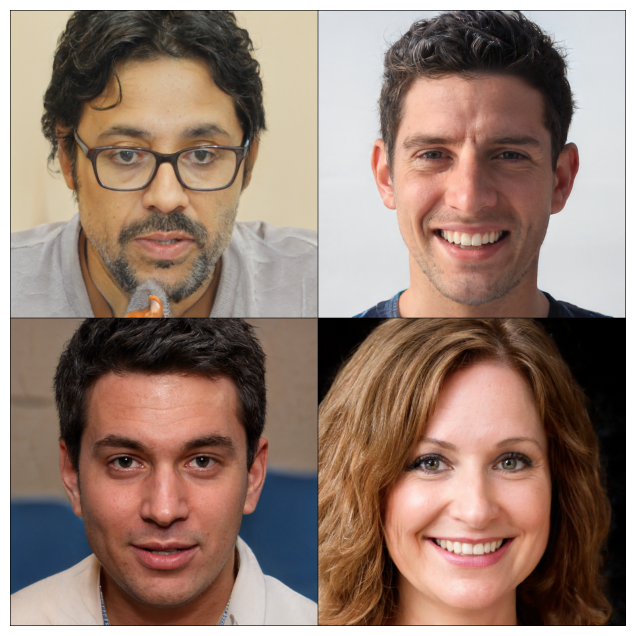

Эпоха 2: loss=0.8838
Эпоха 3: loss=0.8994
Эпоха 4: loss=0.9077
Эпоха 5: loss=0.9150
Эпоха 6: loss=0.9185
Эпоха 7: loss=0.9189
Эпоха 8: loss=0.9170
Эпоха 9: loss=0.9136
Эпоха 10: loss=0.9102
Эпоха 11: loss=0.9067
Эпоха 12: loss=0.9033
Эпоха 13: loss=0.9009
Эпоха 14: loss=0.8979
Эпоха 15: loss=0.8931
Эпоха 16: loss=0.8882
Эпоха 17: loss=0.8838
Эпоха 18: loss=0.8789
Эпоха 19: loss=0.8745
Эпоха 20: loss=0.8696
Эпоха 21: loss=0.8652
Эпоха 22: loss=0.8604
Эпоха 23: loss=0.8545
Эпоха 24: loss=0.8491
Эпоха 25: loss=0.8433
Эпоха 26: loss=0.8379
Эпоха 27: loss=0.8320
Эпоха 28: loss=0.8271
Эпоха 29: loss=0.8223
Эпоха 30: loss=0.8169
Эпоха 31: loss=0.8120
Эпоха 32: loss=0.8076
Эпоха 33: loss=0.8032
Эпоха 34: loss=0.7993
Эпоха 35: loss=0.7954
Эпоха 36: loss=0.7915
Эпоха 37: loss=0.7881
Эпоха 38: loss=0.7842
Эпоха 39: loss=0.7803
Эпоха 40: loss=0.7764
Эпоха 41: loss=0.7729
Эпоха 42: loss=0.7695
Эпоха 43: loss=0.7656
Эпоха 44: loss=0.7627
Эпоха 45: loss=0.7588
Эпоха 46: loss=0.7554
Эпоха 47: loss=0.7

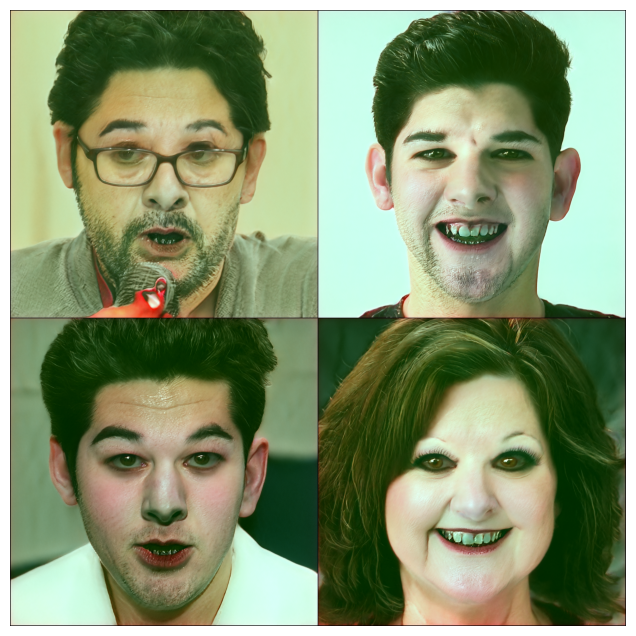

Эпоха 52: loss=0.7358
Эпоха 53: loss=0.7329
Эпоха 54: loss=0.7295
Эпоха 55: loss=0.7266
Эпоха 56: loss=0.7236
Эпоха 57: loss=0.7207
Эпоха 58: loss=0.7178
Эпоха 59: loss=0.7148
Эпоха 60: loss=0.7119
Эпоха 61: loss=0.7085
Эпоха 62: loss=0.7056
Эпоха 63: loss=0.7031
Эпоха 64: loss=0.6997
Эпоха 65: loss=0.6973
Эпоха 66: loss=0.6938
Эпоха 67: loss=0.6914
Эпоха 68: loss=0.6885
Эпоха 69: loss=0.6855
Эпоха 70: loss=0.6831
Эпоха 71: loss=0.6802
Эпоха 72: loss=0.6777
Эпоха 73: loss=0.6748
Эпоха 74: loss=0.6729
Эпоха 75: loss=0.6699
Эпоха 76: loss=0.6675
Эпоха 77: loss=0.6646
Эпоха 78: loss=0.6621
Эпоха 79: loss=0.6592
Эпоха 80: loss=0.6567
Эпоха 81: loss=0.6543
Эпоха 82: loss=0.6514
Эпоха 83: loss=0.6489
Эпоха 84: loss=0.6465
Эпоха 85: loss=0.6436
Эпоха 86: loss=0.6411
Эпоха 87: loss=0.6387
Эпоха 88: loss=0.6357
Эпоха 89: loss=0.6328
Эпоха 90: loss=0.6304
Эпоха 91: loss=0.6284
Эпоха 92: loss=0.6255
Эпоха 93: loss=0.6230
Эпоха 94: loss=0.6206
Эпоха 95: loss=0.6182
Эпоха 96: loss=0.6157
Эпоха 97: 

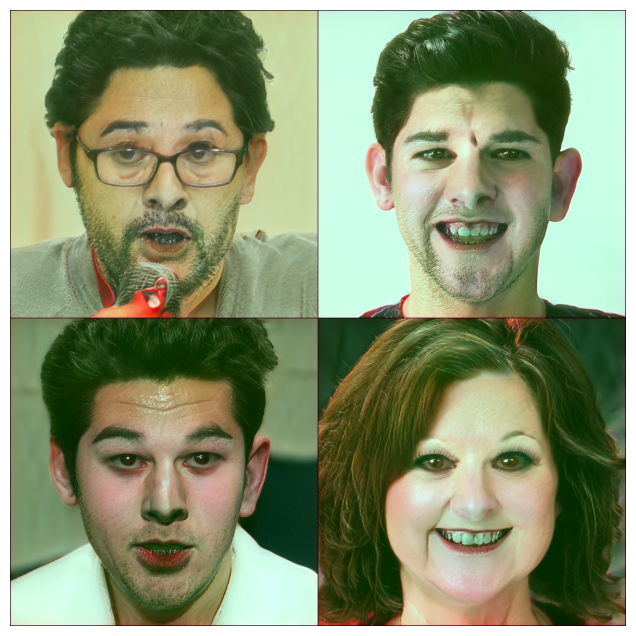

Эпоха 102: loss=0.6035
Эпоха 103: loss=0.6016
Эпоха 104: loss=0.5981
Эпоха 105: loss=0.5957
Эпоха 106: loss=0.5933
Эпоха 107: loss=0.5913
Эпоха 108: loss=0.5884
Эпоха 109: loss=0.5859
Эпоха 110: loss=0.5835
Эпоха 111: loss=0.5811
Эпоха 112: loss=0.5786
Эпоха 113: loss=0.5762
Эпоха 114: loss=0.5737
Эпоха 115: loss=0.5713
Эпоха 116: loss=0.5688
Эпоха 117: loss=0.5664
Эпоха 118: loss=0.5635
Эпоха 119: loss=0.5610
Эпоха 120: loss=0.5591
Эпоха 121: loss=0.5566
Эпоха 122: loss=0.5547
Эпоха 123: loss=0.5542
Эпоха 124: loss=0.5527
Эпоха 125: loss=0.5508
Эпоха 126: loss=0.5479
Эпоха 127: loss=0.5454
Эпоха 128: loss=0.5425
Эпоха 129: loss=0.5400
Эпоха 130: loss=0.5386
Эпоха 131: loss=0.5371
Эпоха 132: loss=0.5337
Эпоха 133: loss=0.5332
Эпоха 134: loss=0.5352
Эпоха 135: loss=0.5312
Эпоха 136: loss=0.5298
Эпоха 137: loss=0.5269
Эпоха 138: loss=0.5254
Эпоха 139: loss=0.5244
Эпоха 140: loss=0.5186
Эпоха 141: loss=0.5166
Эпоха 142: loss=0.5161
Эпоха 143: loss=0.5156
Эпоха 144: loss=0.5146
Эпоха 145: 

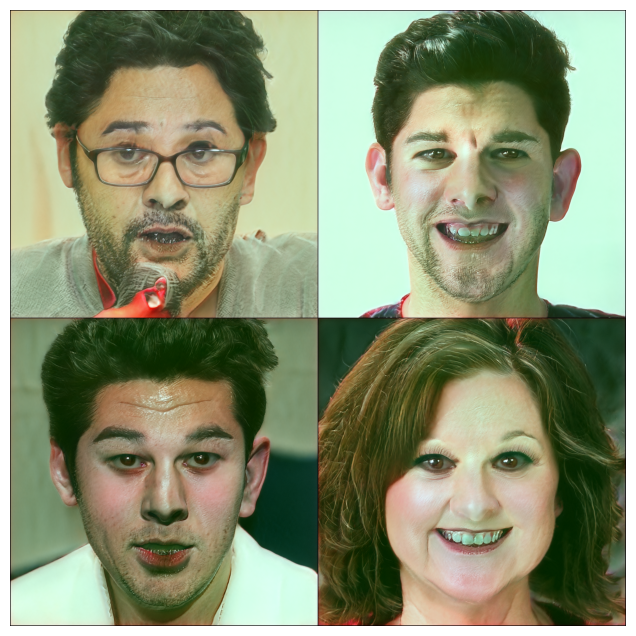

Эпоха 152: loss=0.4939
Эпоха 153: loss=0.4910
Эпоха 154: loss=0.4922
Эпоха 155: loss=0.4915
Эпоха 156: loss=0.4868
Эпоха 157: loss=0.4902
Эпоха 158: loss=0.4878
Эпоха 159: loss=0.4802
Эпоха 160: loss=0.4814
Эпоха 161: loss=0.4766
Эпоха 162: loss=0.4746
Эпоха 163: loss=0.4739
Эпоха 164: loss=0.4746
Эпоха 165: loss=0.4707
Эпоха 166: loss=0.4663
Эпоха 167: loss=0.4648
Эпоха 168: loss=0.4619
Эпоха 169: loss=0.4592
Эпоха 170: loss=0.4595
Эпоха 171: loss=0.4570
Эпоха 172: loss=0.4585
Эпоха 173: loss=0.4585
Эпоха 174: loss=0.4585
Эпоха 175: loss=0.4592
Эпоха 176: loss=0.4561
Эпоха 177: loss=0.4731
Эпоха 178: loss=0.4619
Эпоха 179: loss=0.4663
Эпоха 180: loss=0.4573
Эпоха 181: loss=0.4626
Эпоха 182: loss=0.4612
Эпоха 183: loss=0.4570
Эпоха 184: loss=0.4512
Эпоха 185: loss=0.4502
Эпоха 186: loss=0.4495
Эпоха 187: loss=0.4443
Эпоха 188: loss=0.4409
Эпоха 189: loss=0.4399
Эпоха 190: loss=0.4368
Эпоха 191: loss=0.4346
Эпоха 192: loss=0.4326
Эпоха 193: loss=0.4321
Эпоха 194: loss=0.4353
Эпоха 195: 

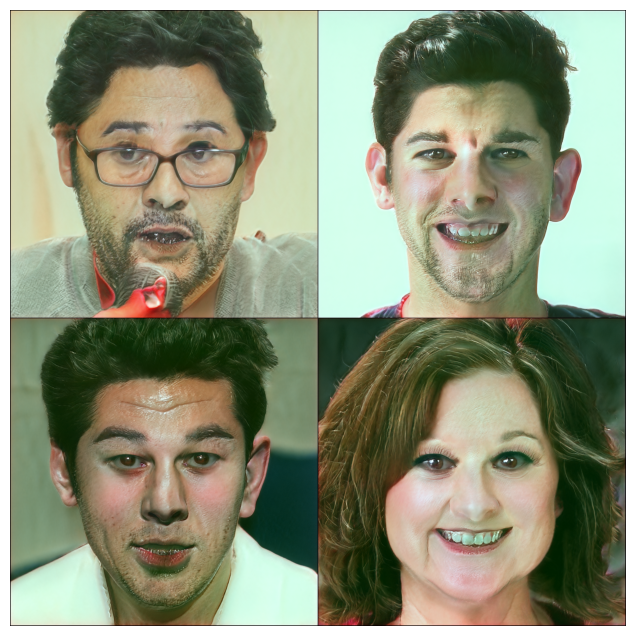

Эпоха 202: loss=0.4199
Эпоха 203: loss=0.4165
Эпоха 204: loss=0.4160
Эпоха 205: loss=0.4106
Эпоха 206: loss=0.4092
Эпоха 207: loss=0.4082
Эпоха 208: loss=0.4119
Эпоха 209: loss=0.4194
Эпоха 210: loss=0.4092
Эпоха 211: loss=0.4045
Эпоха 212: loss=0.4036
Эпоха 213: loss=0.4016
Эпоха 214: loss=0.4028
Эпоха 215: loss=0.3989
Эпоха 216: loss=0.3945
Эпоха 217: loss=0.3965
Эпоха 218: loss=0.3936
Эпоха 219: loss=0.3936
Эпоха 220: loss=0.4036
Эпоха 221: loss=0.3884
Эпоха 222: loss=0.3887
Эпоха 223: loss=0.3926
Эпоха 224: loss=0.3867
Эпоха 225: loss=0.3838
Эпоха 226: loss=0.3779
Эпоха 227: loss=0.3740
Эпоха 228: loss=0.3730
Эпоха 229: loss=0.3730
Эпоха 230: loss=0.3809
Эпоха 231: loss=0.3962
Эпоха 232: loss=0.3972
Эпоха 233: loss=0.3901
Эпоха 234: loss=0.3887
Эпоха 235: loss=0.3870
Эпоха 236: loss=0.3823
Эпоха 237: loss=0.3921
Эпоха 238: loss=0.3838
Эпоха 239: loss=0.3794
Эпоха 240: loss=0.3811
Эпоха 241: loss=0.3875
Эпоха 242: loss=0.3823
Эпоха 243: loss=0.3750
Эпоха 244: loss=0.3757
Эпоха 245: 

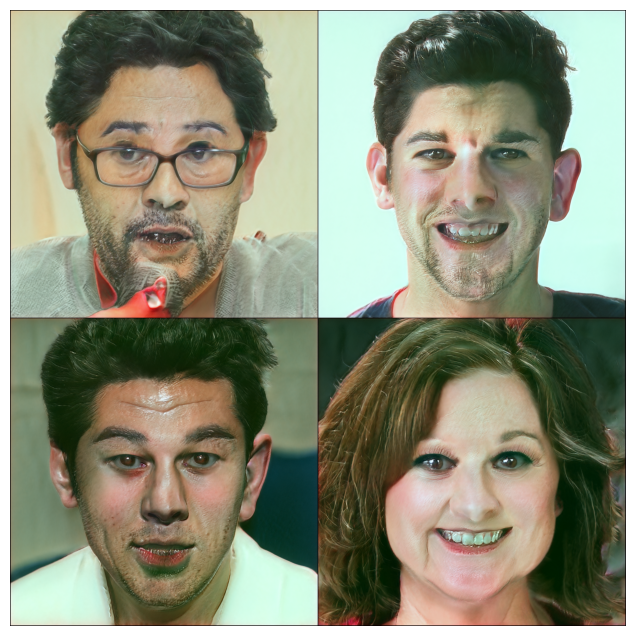

Эпоха 252: loss=0.3765
Эпоха 253: loss=0.3730
Эпоха 254: loss=0.3757
Эпоха 255: loss=0.3699
Эпоха 256: loss=0.3711
Эпоха 257: loss=0.3740
Эпоха 258: loss=0.3701
Эпоха 259: loss=0.3735
Эпоха 260: loss=0.3674
Эпоха 261: loss=0.3608
Эпоха 262: loss=0.3594
Эпоха 263: loss=0.3643
Эпоха 264: loss=0.3567
Эпоха 265: loss=0.3579
Эпоха 266: loss=0.3530
Эпоха 267: loss=0.3557
Эпоха 268: loss=0.3621
Эпоха 269: loss=0.3521
Эпоха 270: loss=0.3499
Эпоха 271: loss=0.3481
Эпоха 272: loss=0.3459
Эпоха 273: loss=0.3428
Эпоха 274: loss=0.3442
Эпоха 275: loss=0.3469
Эпоха 276: loss=0.3545
Эпоха 277: loss=0.3416
Эпоха 278: loss=0.3462
Эпоха 279: loss=0.3474
Эпоха 280: loss=0.3418
Эпоха 281: loss=0.3511
Эпоха 282: loss=0.3494
Эпоха 283: loss=0.3540
Эпоха 284: loss=0.3525
Эпоха 285: loss=0.3794
Эпоха 286: loss=0.3767
Эпоха 287: loss=0.3623
Эпоха 288: loss=0.3662
Эпоха 289: loss=0.3655
Эпоха 290: loss=0.3630
Эпоха 291: loss=0.3613
Эпоха 292: loss=0.3574
Эпоха 293: loss=0.3501
Эпоха 294: loss=0.3491
Эпоха 295: 

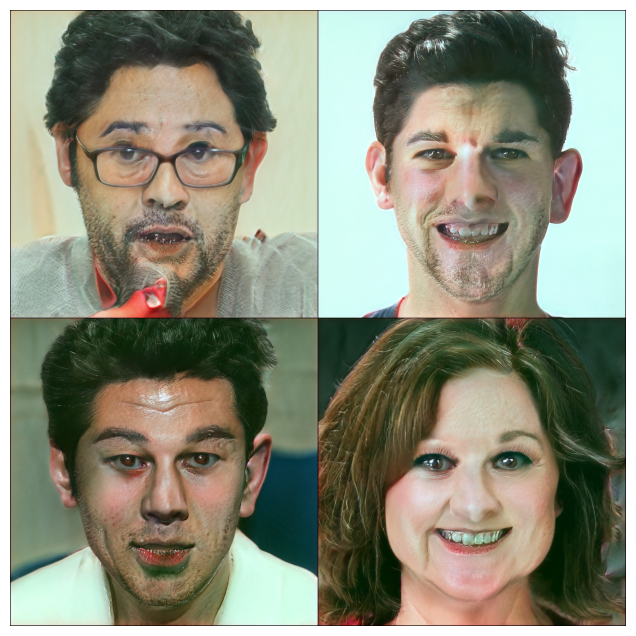

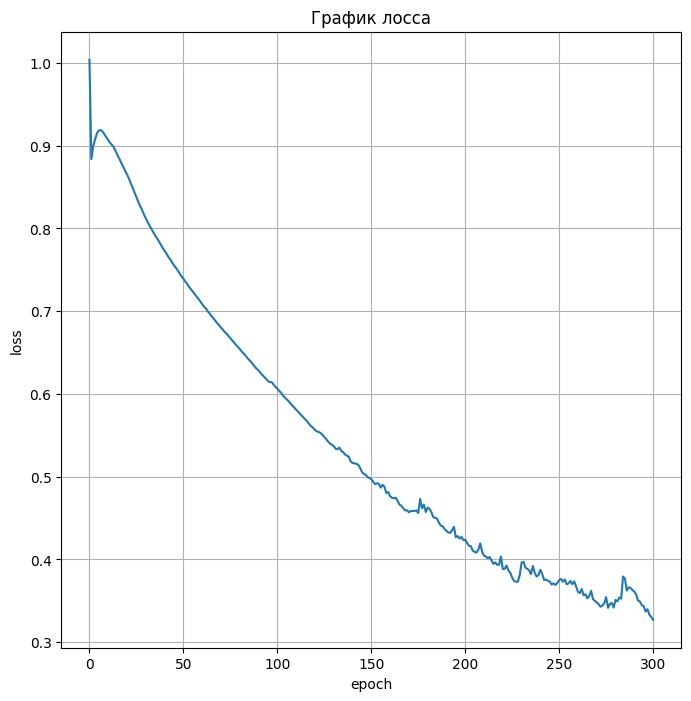

In [16]:
train_generator(generator=G,
                generator_frozen=G_frozen,
                model=model,
                preprocess=preprocess,
                preprocess_text=preprocessing_text,
                preprocess_image=preprocessing_image,
                latent=torch.randn(2, G.z_dim, device=device),
                latent_sample=torch.randn(4, G.z_dim, device=device),
                text_source='human',
                text_target='devil',
                epochs=301,
                criterion=clip_loss,
                device=device,
                lr=0.003,
                c=None)